# Build Docker Images and Register with ECR
This notebook is an extension of the build [CPU](https://github.com/daniel-fudge/sagemaker-tennis/blob/master/build-cpu.ipynb) and [GPU](https://github.com/daniel-fudge/sagemaker-tennis/blob/master/build-gpu.ipynb) notebooks in the related [Tennis](https://github.com/daniel-fudge/sagemaker-tennis) repo. If you are unfamiliar with building Docker images and registering them in AWS [ECR](https://aws.amazon.com/ecr/), please see the [Tennis](https://github.com/daniel-fudge/sagemaker-tennis) repo.

If working on your own fork, you may want to set the following.
```shell
git config --global user.name "Your Name"
git config --global user.email your.email@domain.com
```

#### ECR Access
When you first created an SakeMaker instance either you made or selected a custom role or the system created one for you.  I believe there has been a change in the service since I initially made my `AmazonSageMaker-ExecutionRole`.  To execute the push below I had to add the `AmazonEC2ContainerRegistryFullAccess` policy to my SageMaker [IAM](https://console.aws.amazon.com/iam) role.  Specifically the `ecr:InitiateLayerUpload` access had to be added for images other than the SageMaker images covered in the SageMaker full access policy.

#### Build and register the CPU container

In [1]:
!chmod -R 755 container

In [2]:
!./container/build_and_push.sh

Requesting CPU image
Login Succeeded
Login Succeeded
Sending build context to Docker daemon   3.38MB
Step 1/10 : ARG REGION=us-east-1
Step 2/10 : FROM 520713654638.dkr.ecr.$REGION.amazonaws.com/sagemaker-pytorch:1.1.0-cpu-py3
1.1.0-cpu-py3: Pulling from sagemaker-pytorch

7927d38a: Pulling fs layer 
ac894db4: Pulling fs layer 
2af6d627: Pulling fs layer 
86211d23: Pulling fs layer 
af39bebe: Pulling fs layer 
03f425cd: Pulling fs layer 
1ec18efe: Pulling fs layer 
8ad8ba55: Pulling fs layer 
6c282ffb: Pulling fs layer 
77dfb459: Pulling fs layer 
bbd8c730: Pulling fs layer 
Digest: sha256:bd973d810e8cf494a37dc9cc477b619d13da901d5f2804a953064b5bafc1e484[7A
Status: Downloaded newer image for 520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-pytorch:1.1.0-cpu-py3
 ---> d374fb352c72
Step 3/10 : RUN pip install --upgrade pip
 ---> Running in 81eb72399e62
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
Removing intermediate cont

2d87a08: Pushed    57.1MB/55.66MBPushing  14.33MB/55.66MBlatest: digest: sha256:e225aacee3a98db50650c85ded2763b524aedd28ced49ffa7f94b338272b2217 size: 3881


#### Build and register the GPU container

In [3]:
!./container/build_and_push.sh gpu

Requesting GPU image
Login Succeeded
Login Succeeded
Sending build context to Docker daemon   3.38MB
Step 1/10 : ARG REGION=us-east-1
Step 2/10 : FROM 520713654638.dkr.ecr.$REGION.amazonaws.com/sagemaker-pytorch:1.1.0-gpu-py3
1.1.0-gpu-py3: Pulling from sagemaker-pytorch

7927d38a: Already exists 
ac894db4: Already exists 
2af6d627: Already exists 
86211d23: Already exists 
10d14aae: Pulling fs layer 
65c07c3f: Pulling fs layer 
f79930b5: Pulling fs layer 
3a8ebc21: Pulling fs layer 
1d52b96a: Pulling fs layer 
f9c25cbd: Pulling fs layer 
cb3284f9: Pulling fs layer 
6e5ba5a3: Pulling fs layer 
8ad8ba55: Pulling fs layer 
f2766f46: Pulling fs layer 
1810ab08: Pulling fs layer 
bbd8c730: Pulling fs layer 
Digest: sha256:77a9d1becbcfa69c0b9792779c1ccf2a16ba89591fcc2ad19090fba5075c2f362KDownloading  755.4MB/875.9MBExtracting   31.2MB/120.3MB
Status: Downloaded newer image for 520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-pytorch:1.1.0-gpu-py3
 ---> adbf113505a2
Step 3/10 : RUN pip

  Created wheel for gym: filename=gym-0.17.2-py3-none-any.whl size=1650891 sha256=54f87a8bc20c97c5c2f392bfd8995b4a0e0ad7e70e30e6e19f831efc2e31d2ae
  Stored in directory: /root/.cache/pip/wheels/be/a1/84/6b4caa6c1cea703acbfea8a24cc3c1729bd359cd4a65755d8b
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=e903abe4e56532e597032005fb53c2d1f412c5668ef2cd98e405fd235573b662
  Stored in directory: /root/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
Successfully built gym future
Removing intermediate container 213c7d3b704e
 ---> cffea4cd498f
Step 6/10 : ENV PATH="/opt/ml/code:${PATH}"
 ---> Running in 1b8f17a1a5ff
Removing intermediate container 1b8f17a1a5ff
 ---> 16585cb0a5c5
Step 7/10 : COPY /src /opt/ml/code
 ---> fe90d6a939b1
Step 8/10 : RUN chmod -R 755 /opt/ml/code
 ---> Running in 944e13b5f105
Removing intermediate container 944e13b5f105
 ---> 7ab633156455
Step 9/10 : ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code
 ---> Run

#### Setup Notebook for local execution

In [4]:
!/bin/bash ./utils/setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


#### Train the CPU model locally
Since we only want to check the functionality, we will start at day 2902.  There are only 2922 days worth of signals so we are only letting the model trade for 20 days.

In [6]:
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role

hyperparameters = {'start_day': 2902,
                   'prices_name': 'prices-2019.csv'}
role = get_execution_role()
estimator = Estimator(role=role,
                      train_instance_count=1,
                      train_instance_type='local',
                      image_name='portfolio-optimization-cpu:latest',
                      hyperparameters=hyperparameters)
estimator.fit()

Creating tmp66zd07bj_algo-1-gjmju_1 ... 
Attaching to tmp66zd07bj_algo-1-gjmju_12mdone
algo-1-gjmju_1  | 2020-07-28 16:33:45,918 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
algo-1-gjmju_1  | 2020-07-28 16:33:45,920 sagemaker-containers INFO     Failed to parse hyperparameter prices_name value real-prices.csv to Json.
algo-1-gjmju_1  | Returning the value itself
algo-1-gjmju_1  | 2020-07-28 16:33:45,922 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-gjmju_1  | 2020-07-28 16:33:45,936 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
algo-1-gjmju_1  | 2020-07-28 16:33:45,938 sagemaker_pytorch_container.training INFO     Invoking user training script.
algo-1-gjmju_1  | 2020-07-28 16:33:45,939 sagemaker-containers INFO     Module train does not provide a setup.py. 
algo-1-gjmju_1  | Generating setup.py
algo-1-gjmju_1  | 2020-07-28 16:33:45,939 sagemaker-containers INFO     G

algo-1-gjmju_1  | 2020-07-28 16:41:21,666 sagemaker-containers INFO     Reporting training SUCCESS
tmp66zd07bj_algo-1-gjmju_1 exited with code 0
Aborting on container exit...


===== Job Complete =====


### Train on SageMaker

#### Locate the ECR image just built and pushed

In [7]:
import boto3

client = boto3.client('sts')
account = client.get_caller_identity()['Account']
region = boto3.Session().region_name
ecr_image = '{}.dkr.ecr.{}.amazonaws.com/portfolio-optimization-cpu:latest'.format(account, region)

print(ecr_image)

031118886020.dkr.ecr.us-east-1.amazonaws.com/portfolio-optimization-cpu:latest


#### Submit the training job

In [8]:
from sagemaker.estimator import Estimator
estimator = Estimator(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m5.large',
                      image_name=ecr_image,
                      train_use_spot_instances=True,
                      train_max_run=14400,
                      train_max_wait=14400,
                      hyperparameters=hyperparameters)
estimator.fit()

2020-07-28 16:41:22 Starting - Starting the training job...
2020-07-28 16:41:24 Starting - Launching requested ML instances......
2020-07-28 16:42:46 Starting - Preparing the instances for training......
2020-07-28 16:43:42 Downloading - Downloading input data
2020-07-28 16:43:42 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-28 16:44:35,082 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-28 16:44:35,083 sagemaker-containers INFO     Failed to parse hyperparameter prices_name value real-prices.csv to Json.
Returning the value itself
2020-07-28 16:44:35,085 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-28 16:44:35,095 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-28 16:44:35,096 sagemaker_pytorch_container.training INFO     Invoking user

### Get the results

#### Get the bucket name

In [9]:
from sagemaker.session import Session

sagemaker_session = Session()
bucket = sagemaker_session.default_bucket()
job_name = estimator._current_job_name
print(bucket)
print(job_name)

sagemaker-us-east-1-031118886020
portfolio-optimization-cpu-2020-07-28-16-41-22-359


#### Copy and unpack the result archive
Since we didn't start trading until nearly the end, the results are as expected.

In [10]:
import shutil

s3 = boto3.resource('s3')
key = '{}/output/output.tar.gz'.format(estimator._current_job_name)
print(key)
s3.Bucket(bucket).download_file(key, 'output.tar.gz')
shutil.unpack_archive('output.tar.gz')

portfolio-optimization-cpu-2020-07-28-16-41-22-359/output/output.tar.gz


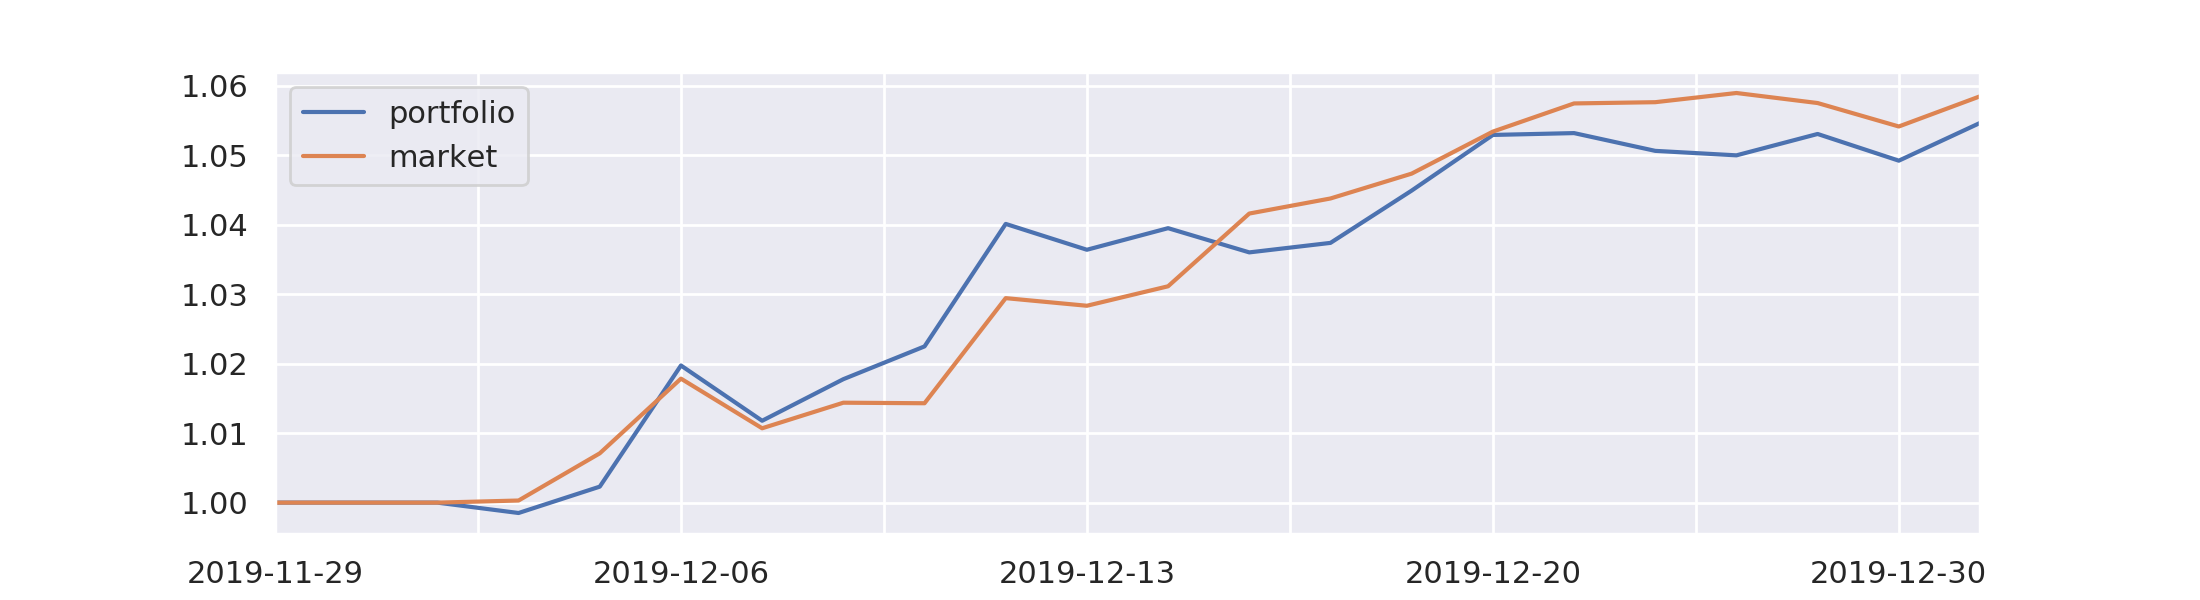

In [11]:
from IPython.display import Image
Image(filename='history.png') 

# References
- [Tennis Repo](https://github.com/daniel-fudge/sagemaker-tennis)
- [Amazon ECS](https://aws.amazon.com/ecs/)

#### SageMaker
- [SageMaker Example:  Extending PyTorch Container](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/pytorch_extending_our_containers)
- [How Amazon SageMaker interacts with your Docker container for training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html)
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk)
- [scikit-bring-your-own](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb)
- [SageMaker PyTorch container](https://github.com/aws/sagemaker-pytorch-container)
- [SageMaker Instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/)
- [SageMaker Instance prices](https://aws.amazon.com/sagemaker/pricing/)

#### Docker
- [Dockerfile](https://docs.docker.com/engine/reference/builder/)
- [Docker home page](http://www.docker.com)
- [Getting started with Docker](https://docs.docker.com/get-started/)
- [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
- [docker run reference](https://docs.docker.com/engine/reference/run/)